In [1]:
import tensorflow as tf

2024-01-21 15:46:17.043191: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [3]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation

In [4]:
# Defining the path for train and test images
root_path = '/home/jovyan/examples/examples/tensorflow/data'
data_dir_train = pathlib.Path(root_path + '/train')
data_dir_test = pathlib.Path(root_path + '/test')

In [15]:
image_count_train = len(list(data_dir_train.glob('*/*.png')))
print(image_count_train)
image_count_test = len(os.listdir(data_dir_test))
print(image_count_test)

4750
794


This project uses a dataset of about 4750 images of plant seedling types. The dataset contains 12 sub-directories in each train and test subdirectories. The 12 sub-directories contains the images of 12 plant seedling types respectively.

### Load using keras.preprocessing

### Creating the dataset

In [5]:
# specifying the batch size and image dimensions
batch_size = 32
img_height = 120
img_width = 120

In [6]:
# creating train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="training", seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

Found 4750 files belonging to 12 classes.
Using 3800 files for training.


2024-01-21 15:46:35.806102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-21 15:46:35.811639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-21 15:46:35.811908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-21 15:46:35.812468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [7]:
train_ds.class_names

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [20]:
# creating validation dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="validation", seed=123,
                                                             image_size=(img_height, img_width), batch_size=batch_size)

Found 4750 files belonging to 12 classes.
Using 950 files for validation.


In [21]:
# Listing out all the classes of plant seedlings and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
labels = sorted(os.listdir(data_dir_train))
print(labels)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [16]:
# creating a list which counts the number of images in each class of plant seedling
count_plot = []
for i in labels:
    count_plot.append(len(os.listdir(os.path.join(data_dir_train,i))))

In [17]:
count_plot

[263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385]

### Visualizing the data

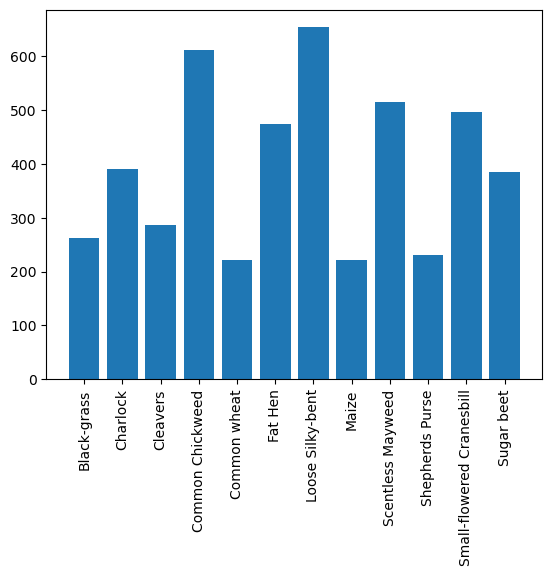

In [18]:
# creating plot for distribution of images in each class
count_plot = np.array(count_plot)
plt.bar(labels, count_plot)
plt.xticks(rotation = 90)
plt.show()

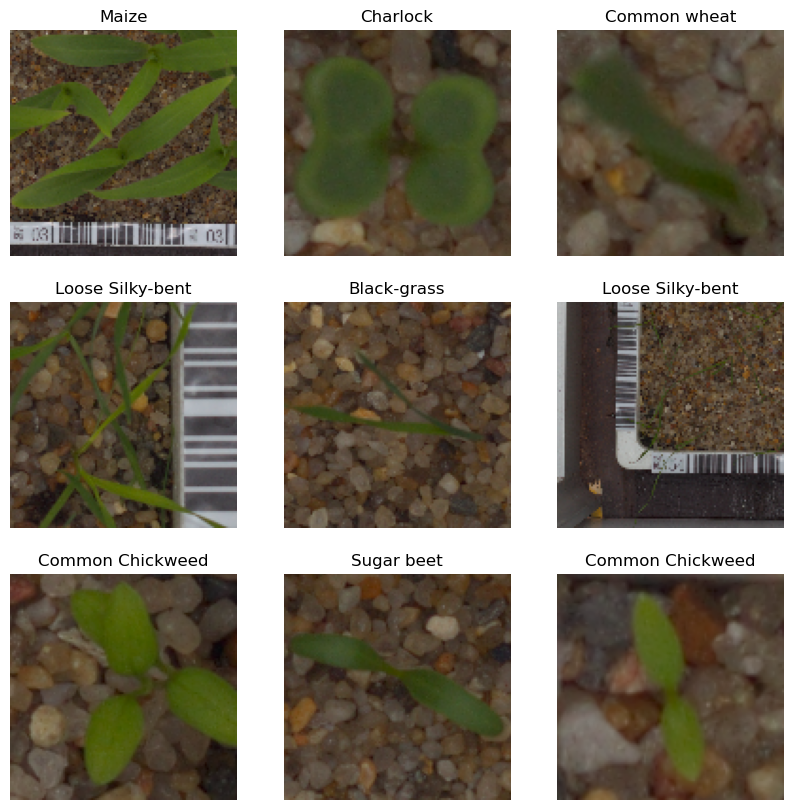

In [19]:
# visualizing few images from the train data
plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(labels[label[i]])
    plt.axis("off")

In [20]:
#Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.
#Dataset.prefetch() overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating the model

### Model 1
Creating a CNN model, which can accurately detect 12 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [22]:
# specifying image dimensions with RGB channel
input_shape = (120, 120, 3)
# storing number of classes of plant seedlings in a variable
num_classes = 12

# creating the model using Sequential API
model = Sequential([
    Rescaling(1./255, offset=0.0, input_shape=input_shape),
    
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])


In [23]:
# compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 120, 120, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 118, 118, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 118, 118, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0

In [24]:
### Training the model
epochs = 20
batch_size = 32
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/20


2024-01-20 13:39:08.043384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 56 of 1000
2024-01-20 13:39:16.530459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2024-01-20 13:39:17.128417: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-01-20 13:39:19.154676: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-20 13:39:19.155268: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-20 13:39:19.155305: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-20 13:39:19.155984: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-20 13:39:19.156083: W tensorflow/stream_execut

119/119 [==============================] - 36s 97ms/step - loss: 2.7979 - accuracy: 0.5266 - val_loss: 21.1973 - val_accuracy: 0.1463
Epoch 2/20
119/119 [==============================] - 6s 46ms/step - loss: 0.7750 - accuracy: 0.7497 - val_loss: 15.7290 - val_accuracy: 0.1463
Epoch 3/20
119/119 [==============================] - 6s 46ms/step - loss: 0.4343 - accuracy: 0.8516 - val_loss: 11.2562 - val_accuracy: 0.1495
Epoch 4/20
119/119 [==============================] - 6s 46ms/step - loss: 0.2976 - accuracy: 0.8955 - val_loss: 3.6928 - val_accuracy: 0.3663
Epoch 5/20
119/119 [==============================] - 6s 47ms/step - loss: 0.2232 - accuracy: 0.9211 - val_loss: 1.3722 - val_accuracy: 0.6916
Epoch 6/20
119/119 [==============================] - 6s 47ms/step - loss: 0.1176 - accuracy: 0.9576 - val_loss: 1.0709 - val_accuracy: 0.7558
Epoch 7/20
119/119 [==============================] - 6s 47ms/step - loss: 0.1046 - accuracy: 0.9637 - val_loss: 1.1114 - val_accuracy: 0.7937
Epoch 

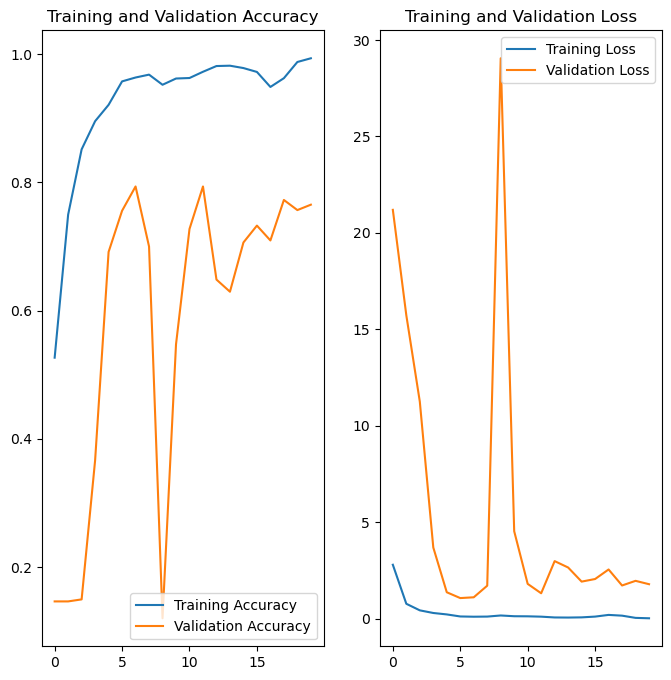

In [25]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Results from Model 1
1. The accuracy of the model for the Training data set is at 97%. But the Validation accuracy is not in par with the training accuracy.
It is only at 78%. 
2. The validation loss (1.7326) as observed is very high.This could also be indicative of some Overfitting in the model.
3. We could add some Dropout layers and remove the BatchNormalization layers to avoid overfitting to some extent

### Model 2
#### Removing Batch Normalization and Adding Dropouts.
Removing Batch Normalization for this layer and adding dropouts after every hidden layer to avoid overfitting

In [32]:
# specifying image dimensions with RGB channel
input_shape = (120, 120, 3)
# storing number of classes of plant seedlings in a variable
num_classes = 12

# creating the model using Sequential API
model2 = Sequential([
    Rescaling(1./255, offset=0.0, input_shape=input_shape),
    
    Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape, activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.50),
    
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.50),
    
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.50),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.50),
    Dense(num_classes, activation='softmax')
])


In [33]:
### compiling the model
### choosing an appropirate optimiser and loss function
opt = Adam(0.001) # specifying the optimizer used for the model
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
# specifying the format in which model needs to be saved
model_name = 'Seed2' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path       
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping]

In [35]:
### training the model and using callback parameter to save the best model
epochs = 50
batch_size = 32
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 2.4424 - accuracy: 0.1279
Epoch 1: val_loss improved from inf to 2.39452, saving model to Seed2/model-00001-2.44242-2.39452-.h5
119/119 [==============================] - 5s 41ms/step - loss: 2.4424 - accuracy: 0.1279 - val_loss: 2.3945 - val_accuracy: 0.2337
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 1.9963 - accuracy: 0.3161
Epoch 2: val_loss improved from 2.39452 to 1.60570, saving model to Seed2/model-00002-1.99629-1.60570-.h5
119/119 [==============================] - 5s 39ms/step - loss: 1.9963 - accuracy: 0.3161 - val_loss: 1.6057 - val_accuracy: 0.4684
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 1.5664 - accuracy: 0.4547
Epoch 3: val_loss improved from 1.60570 to 1.28183, saving model to Seed2/model-00003-1.56640-1.28183-.h5
119/119 [==============================] - 5s 40ms/step - loss: 1.5664 - accuracy: 0.4547 - val_loss: 1.2818 - val_accuracy: 0.5589
Ep

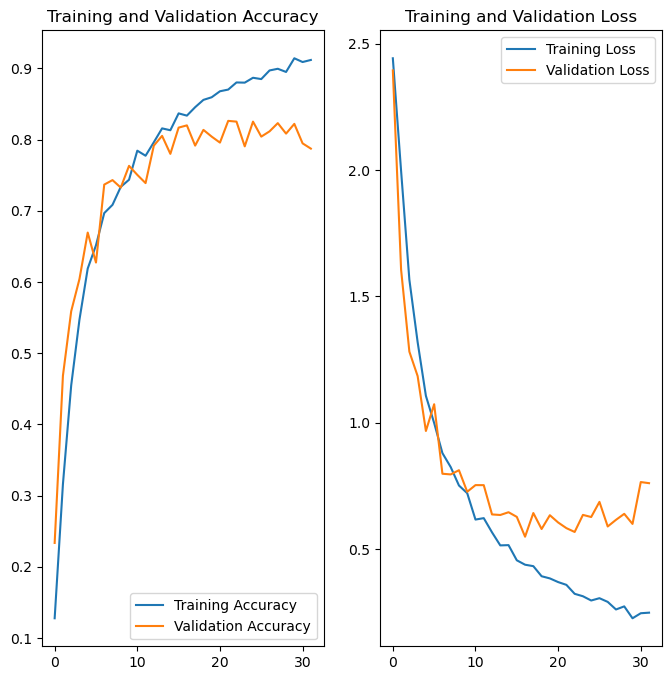

In [36]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(32)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Results from Model 2
1. The model is performing better than the previous model since there is comparatively less overfitting.
2. Training accuracy of 90% and validation accuracy of 82%.
3. Early Stopping used.
4. Validation loss improved from 1.7 to 0.55

## Model 3 
#### Creating a model using data augmetation
1. layers.experimental.preprocessing.RandomFlip() - A preprocessing layer which randomly flips images during training.
2. layers.experimental.preprocessing.RandomRotation() - A preprocessing layer which randomly rotates images during training.

In [38]:
# specifying image dimensions with RGB channel
input_shape = (120, 120, 3)
# storing number of classes of plant seedlings in a variable
num_classes = 12

# creating the model using Sequential API
model_aug = Sequential([
    Rescaling(1./255, offset=0.0),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    
    Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same', activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.50),
    
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.50),
    
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.50),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.50),
    Dense(num_classes, activation='softmax')
])



In [39]:
### compiling the augmented model
### choosing an appropirate optimiser and loss function
model_aug.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# spefying the format in which model needs to be saved
model_name = 'Seed3' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path       
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping]

In [41]:
### training the model
epochs = 100
batch_size = 32
history = model_aug.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 2.4339 - accuracy: 0.1363
Epoch 1: val_loss improved from inf to 2.42856, saving model to Seed3/model-00001-2.43387-2.42856-.h5
119/119 [==============================] - 8s 60ms/step - loss: 2.4339 - accuracy: 0.1363 - val_loss: 2.4286 - val_accuracy: 0.1611
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 2.1224 - accuracy: 0.2703
Epoch 2: val_loss improved from 2.42856 to 1.70378, saving model to Seed3/model-00002-2.12241-1.70378-.h5
119/119 [==============================] - 7s 59ms/step - loss: 2.1224 - accuracy: 0.2703 - val_loss: 1.7038 - val_accuracy: 0.4200
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 1.6577 - accuracy: 0.4113
Epoch 3: val_loss improved from 1.70378 to 1.44041, saving model to Seed3/model-00003-1.65771-1.44041-.h5
119/119 [==============================] - 7s 59ms/step - loss: 1.6577 - accuracy: 0.4113 - val_loss: 1.4404 - val_accuracy: 0.4937

119/119 [==============================] - ETA: 0s - loss: 0.3503 - accuracy: 0.8787
Epoch 55: val_loss did not improve from 0.31108
119/119 [==============================] - 7s 57ms/step - loss: 0.3503 - accuracy: 0.8787 - val_loss: 0.3823 - val_accuracy: 0.8737
Epoch 56/100
119/119 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8779
Epoch 56: val_loss did not improve from 0.31108
119/119 [==============================] - 7s 57ms/step - loss: 0.3638 - accuracy: 0.8779 - val_loss: 0.4051 - val_accuracy: 0.8716
Epoch 57/100
119/119 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.8797
Epoch 57: val_loss did not improve from 0.31108
119/119 [==============================] - 7s 57ms/step - loss: 0.3404 - accuracy: 0.8797 - val_loss: 0.3823 - val_accuracy: 0.8674
Epoch 58/100
119/119 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.8800
Epoch 58: val_loss improved from 0.31108 to 0.29181, saving model to Seed3/model-

In [42]:
### summary of the above model
model_aug.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 120, 120, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 120, 120, 3)      0         
 tion)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 120, 120, 32)      896       
                                                                 
 conv2d_19 (Conv2D)          (None, 118, 118, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                  

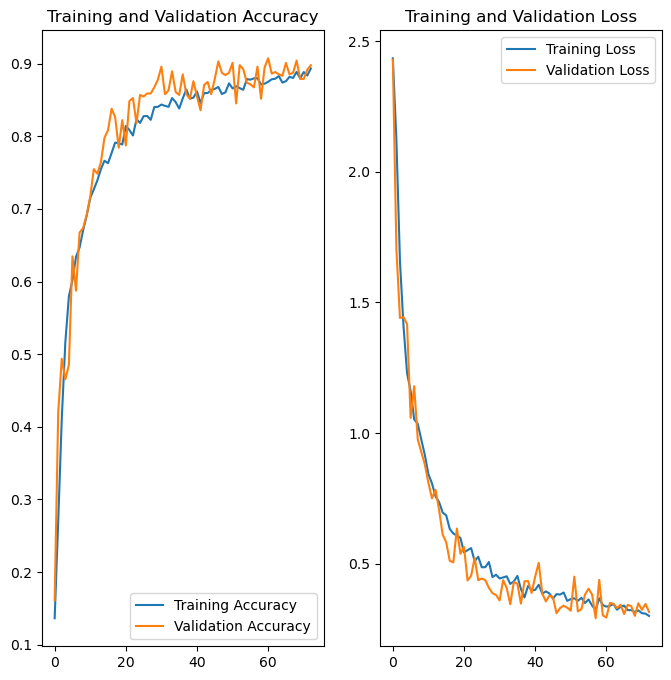

In [43]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(73)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Results from Model 3
1. Including Data Augmentation has improved the model accuracy to 90% and also handled overfitting to great extent.
2. Data Augmentation has improved the model performance.
3. Validation loss have improved from 0.55 to 0.25